In [335]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp

In [336]:
# #Number of simulation
# n=53

# #choose between 'local' or 'dahu'
# where='dahu'


# #Reading the netcdf file
# if where=='local':
#     if n<10:
#         simu_name='outdir_000'+str(n)
#     elif n<100 and n>=10:
#         simu_name='outdir_00'+str(n)
#     Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

# elif where=='dahu':
#     simu_name='dahu_'+str(n)
#     Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'

# else:
#     print('Error: where not recognized')
#     sys.exit()
# print('la simulation chargée est: ' + simu_name )
# print("depuis: "+where)

# filenames=['/vars.nc']



# dataset=nc.Dataset(Path+filenames[0])
# print(dataset.variables.keys())

# t=dataset.variables['time'][:]
# x=dataset.variables['x'][:]
# y=dataset.variables['y'][:]
# psi=dataset.variables['psi'][:,:,:,:]
# q=dataset.variables['q'][:,:,:,:]

# print("psi shape",psi.shape)

# #Lecture des paramètres :

# param=io.read_params(Path)
# print(param)
# f0= param['f0']
# beta=param['beta']
# hEkb=param['hEkb']
# dh=param['dh'][0]
# Lx=param['Lx']
# nx=param['NX']
# ny=param['NY']
# k_f=param['k_f']
# sigma_f=param['sigma_f']
# bc_fac=param['bc_fac']
# nu_hyper=param['nu_hyper']
# n_hyper=param['n_hyper']
# dt_out=param['dt_out']

# Computing Fourier Transform

In [337]:
#Function that gives the real and imaginary part of the Fourier transform of psi at a given time and a given wavenumber k,l

def fft2d_RI(psi,k,l,Lx,nx,ny,time_tab):

    real_part_tab=np.zeros_like(time_tab,dtype=float)
    imag_part_tab=np.zeros_like(time_tab,dtype=float)
    dx=Lx/nx/(2*np.pi)
    dy=Lx/ny/(2*np.pi)

    kx=np.fft.fftfreq(int(nx),d=dx)
    ky=np.fft.fftfreq(int(ny),d=dy)
    kx_reshaped=np.zeros_like(kx)
    kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
    kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

    ky_reshaped=np.zeros_like(ky)
    ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
    ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

    Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
    Ky=np.flipud(Ky)
    

    for i,time_sel in enumerate(time_tab):

        psi_data=psi[time_sel,:,:]

        # 2D Fourier Transform
        fft_result = np.fft.fft2(psi_data[:,:])
        fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center


        # Convert wavenumbers to indices
        # Find the index of the closest value to k in freqs_x
        k_index = np.argmin(np.abs(k - kx_reshaped))

        # Find the index of the closest value to l in freqs_y
        l_index = np.argmin(np.abs(l - ky_reshaped))
        
        
        # Extract the complex value at (k_index, l_index)
        complex_value = fft_shifted[l_index,k_index]

        # Get real and imaginary parts
        real_part_tab[i] = np.real(complex_value)
        imag_part_tab[i] = np.imag(complex_value)

        # Print the results
        #print(f"Complex value at (k, l) = ({k}, {l}): {complex_value}")
        #print(f"Real part: {real_part_tab[i]}")
        #print(f"Imaginary part: {imag_part_tab[i]}")

        #print("Amplitude",np.sqrt(real_part_tab[i]**2+imag_part_tab[i]**2))
    return real_part_tab,imag_part_tab



In [338]:
#Function to find the mode with the maximum amplitude

def find_mode_max_amplitude(psi,Lx,nx,ny,time_tab):

    k_max=np.pi*2 / (Lx/(nx-1))
    k_min=2*np.pi/(Lx)

    k_step=(k_max-k_min)/(nx)

    #Making the arrays of wavenumbers we try
    k_range = np.arange(0, k_max, k_step)
    #l_range = np.arange(k_min, k_max, k_step)
    print("len k_range",len(k_range))
    print("k_min",k_min)
    print("k_max",k_max)
    amplitude_max=0
    k_ampmax=0
    l_ampmax=0
    #Going through all the wavenumbers
    for k in k_range:
        for l in k_range:
            real,im=fft2d_RI(psi,k,l,Lx,nx,ny,time_tab)
            amplitude=np.sqrt(real[0]**2+im[0]**2)
            if (amplitude > amplitude_max):
                amplitude_max=amplitude
                k_ampmax=k
                l_ampmax=l
    return k_ampmax,l_ampmax,amplitude_max

In [339]:
#function to determine the pulsation of the signal (omega=dteta/dt)
def pulsation(real_part_tab,imag_part_tab,t):
    """
    real_part_tab,imag_part_tab: array of the real part and imaginary part of the Fourier transform of psi of the wave isolated
    t: time array
    """
    arg_tab=np.arctan(imag_part_tab/real_part_tab)
    pulsation_observed=np.mean((arg_tab[1:]-arg_tab[0:-1])/(t[1]-t[0]))

    return pulsation_observed





# Test Lennard Wave

In [340]:
#Dataset of Lennard :

#Reading the netcdf file
dataset=nc.Dataset('wave.nc')
print(dataset.variables.keys())


psi_lennard=dataset.variables['__xarray_dataarray_variable__'][:,:,:]
t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]


Lx=x[-1]-x[0]
nx=len(x)
ny=len(y)

k_max=np.pi*2/(x[1]-x[0])
k_min=2*np.pi/(x[-1]-x[0])

print("kmax=",k_max,"kmin=",k_min)

dx=Lx/nx/(2*np.pi)
dy=Lx/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)



dict_keys(['__xarray_dataarray_variable__', 'time', 'x', 'y'])
kmax= 0.00015707963267948965 kmin= 1.5866629563584814e-06


In [341]:
#Finding the mode with the maximum amplitude

time_tab=np.array([5])

k_found,l_found,amp_max=find_mode_max_amplitude(psi_lennard,Lx,nx,ny,time_tab)
print("k_max=",k_found,"l_max=",l_found," For an amplitude of",amp_max)


len k_range 102
k_min 1.5866629563584814e-06
k_max 0.00015707963267948965


k_max= 7.774648486156557e-06 l_max= 3.109859394462623e-06  For an amplitude of 4999.999999999999


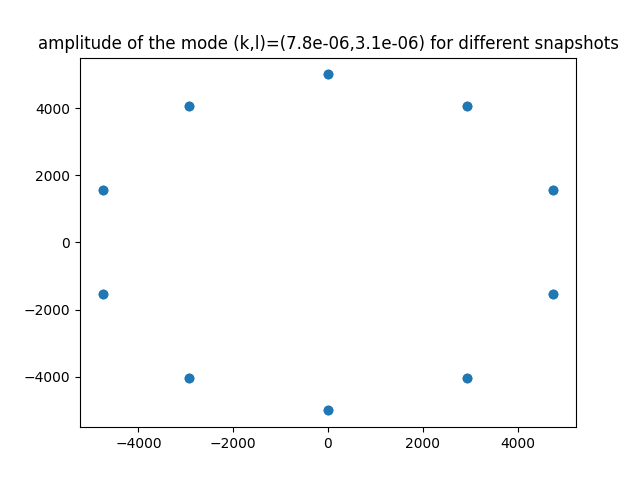

In [342]:
#Select time
time_sel_tab=np.arange(0,len(t),5)

k_test=k_found
l_test=l_found

real_part_tab,imag_part_tab=fft2d_RI(psi_lennard[:,:,:],k_test,l_test,Lx,nx,ny,time_sel_tab)

plt.figure()
plt.scatter(real_part_tab,imag_part_tab,label='mode (k,l)=(32,0)')
plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()


# fft_result = np.fft.fft2(psi_lennard[time_sel,:,:])

# fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

# #Calculating Energy
# energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2

# # Step 3: Plot the Spectrum

# plt.figure(figsize=(12, 6))
# plt.imshow(np.log(energy_spectrum +1e-5),  extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=-10,vmax=10)


# plt.colorbar(label='Log Energy')
# plt.xlabel('k')
# plt.ylabel('l')
# plt.title('Instantaneous Energy Spectrum in (k, l) Space')
# plt.show()


In [343]:
#Determining the pulsation of the signal:

pulsation_observed=np.pi*2*pulsation(real_part_tab,imag_part_tab,t)
print(pulsation_observed)

-3.629764065335759e-06


In [344]:
#Finding beta
beta=-(k_test**2+l_test**2)*pulsation_observed/k_test
print("beta=",beta)

beta= 3.273536204697503e-11


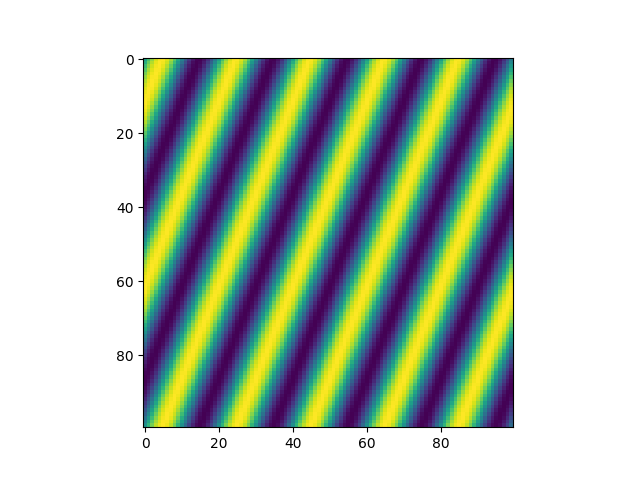

In [345]:
time_sel=1

plt.figure()
plt.imshow(psi_lennard[time_sel,:,:])
plt.show()

# Home-made Wave

In [347]:
#Test avec une onde de Rossby


#Reading the netcdf file
dataset=nc.Dataset('rossby_wave.nc')
print(dataset.variables.keys())
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi_rossby=dataset.variables['psi'][:,:,:]
print(np.shape(psi_rossby))
t=dataset.variables['t'][:]


# Grid and time parameters
Lx=x[-1]-x[0]
nx=len(x)
ny=len(y)  



dict_keys(['x', 'y', 't', 'psi'])
(150, 256, 256)


In [348]:
#Finding the mode with the maximum amplitude

time_tab=np.array([5])

k_found,l_found,amp_max=find_mode_max_amplitude(psi_rossby,Lx,nx,ny,time_tab)
print("k_max=",k_found,"l_max=",l_found," For an amplitude of",amp_max)


len k_range 258
k_min 0.9999999721724656
k_max 254.99999290397872
k_max= 31.74999911647578 l_max= 0.0  For an amplitude of 31879.408522383463


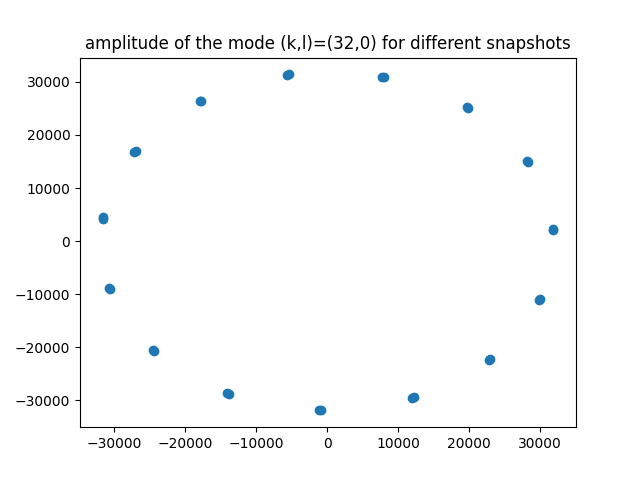

In [349]:
#Select time
time_sel_tab=np.arange(0,len(t),5)

k_test=k_found
l_test=l_found

real_part_tab,imag_part_tab=fft2d_RI(psi_rossby[:,:,:],k_test,l_test,Lx,nx,ny,time_sel_tab)

plt.figure()
plt.scatter(real_part_tab,imag_part_tab,label='mode (k,l)=(32,0)')
plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()


In [350]:
#Determining the pulsation of the signal:

pulsation_observed=np.pi*2*pulsation(real_part_tab,imag_part_tab,t)
print(pulsation_observed)

0.13026315691938703


In [351]:
#Finding beta
beta=(k_test**2+l_test**2)*pulsation_observed/k_test
print("beta=",beta)

beta= 4.135855117099884


The homade wave was disgned originally with k=32,l=0 and beta= 4

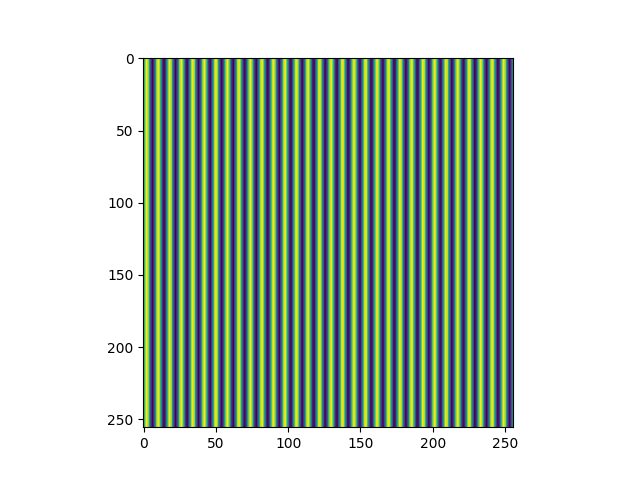

In [352]:
#Plotting the wave
plt.figure()
plt.imshow(psi_rossby[1,:,:])
plt.show()